### Import Libraries

In [1]:
import sys

sys.path.append('..')

In [188]:
import utils.data
import utils.trans
import utils.extract
import utils.visualize
import utils.features

In [189]:
from importlib import reload

In [190]:
reload(utils.data)
reload(utils.trans)
reload(utils.extract)
reload(utils.visualize)
reload(utils.features)

<module 'utils.features' from '..\\utils\\features.py'>

### Load Data

In [191]:
# file_dir = "..\\..\\datasets\\audio\\audio_speech_actors\\Actor_01"
# file_name = "03-01-01-01-01-01-01.wav"

file_dir = "..\\data\\self_recordings"
file_name = 'queen.wav'

file_path = file_dir + "\\" + file_name

In [192]:
x = {}

In [193]:
x['wave'] = utils.data.load_wave(file_path)

### Frequency Transforms

In [194]:
x['stft'] = utils.trans.apply(x['wave'], 
    func=utils.trans.wave_to_stft, 
    func_params=utils.extract.params['stft'])

x['mel'] = utils.trans.apply(x['wave'], 
    func=utils.trans.wave_to_mel, 
    func_params=utils.extract.params['mel'])

x['cqt'] = utils.trans.apply(x['wave'], 
    func=utils.trans.wave_to_cqt, 
    func_params=utils.extract.params['cqt'])

x['features'] = utils.features.signal_features(x)

In [195]:
type(x['features'])

numpy.ndarray

In [184]:
utils.visualize.display_shapes(x)   

x:
--wave:
  --s: (440320,)
  --t: (440320,)
--stft:
  --s: (2049, 1721)
  --c: (300, 1721)
  --f_phase: (2049, 1721)
  --f: (2049,)
  --t: (1721,)
--mel:
  --s: (256, 1721)
  --c: (256, 1721)
  --f: (256,)
  --t: (1721,)
--cqt:
  --s: (2048, 1721)
  --c: (300, 1721)
  --f_phase: (2048, 1721)
  --f: (2048,)
  --t: (1721,)
--features: (53, 1721)


### View Example

In [185]:
reload(utils.visualize)

<module 'utils.visualize' from '..\\utils\\visualize.py'>

In [186]:
# figsize = (15, 1.5)
figsize = (15, 5)
cmap_spec = 'magma'

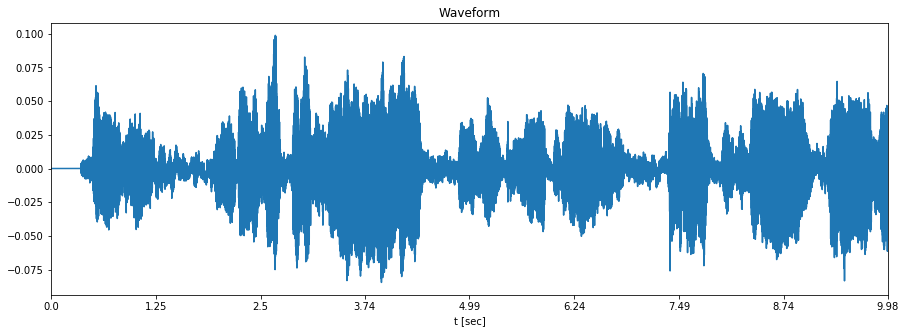

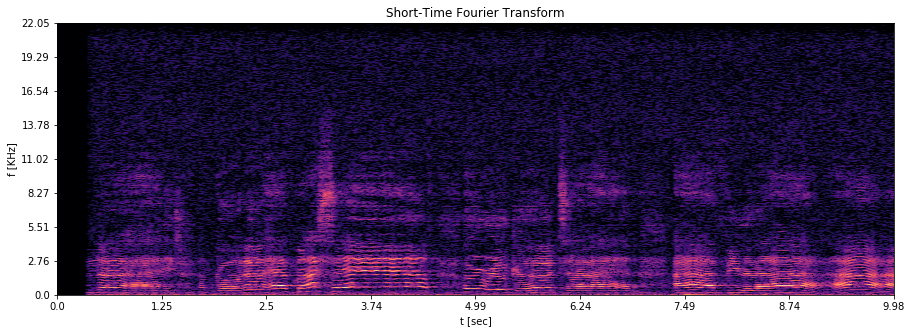

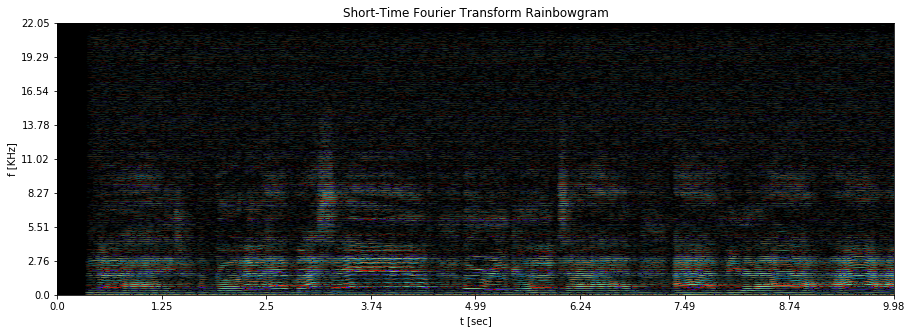

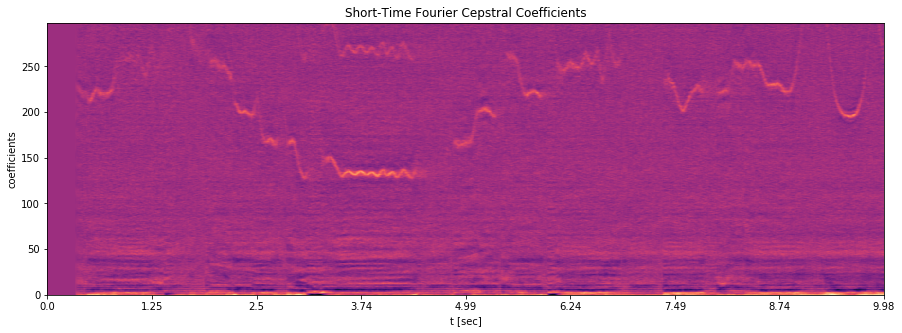

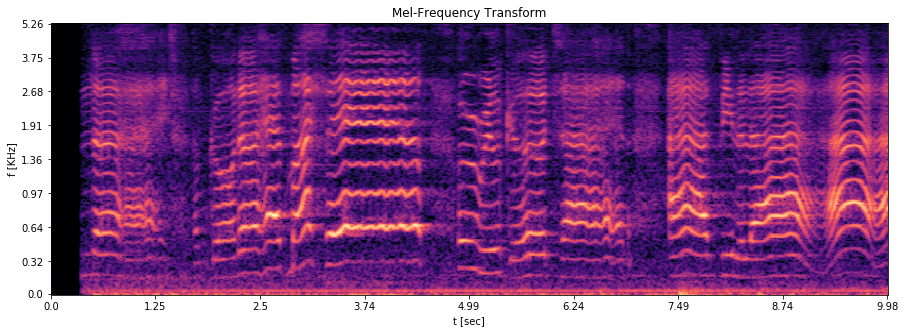

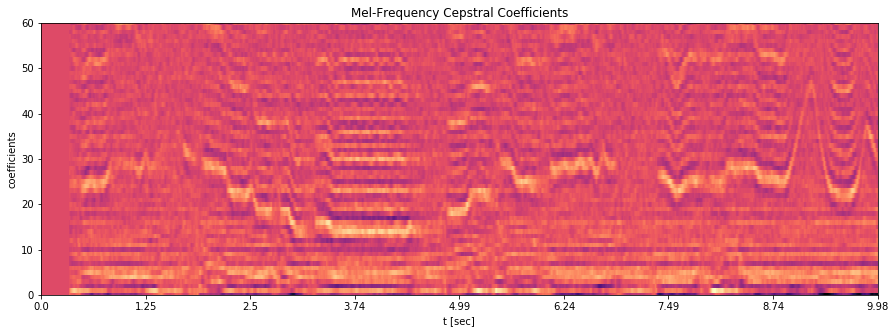

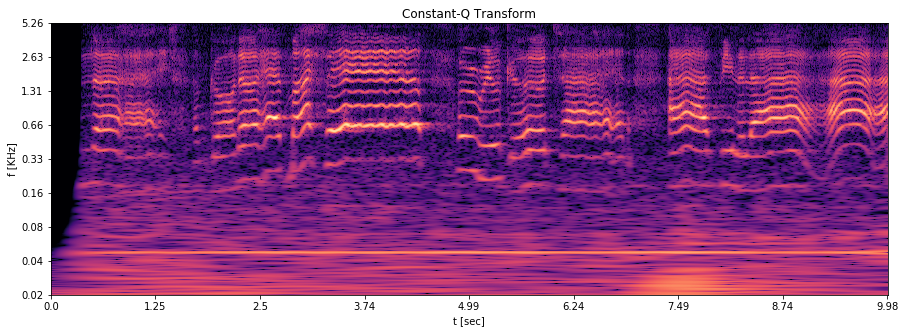

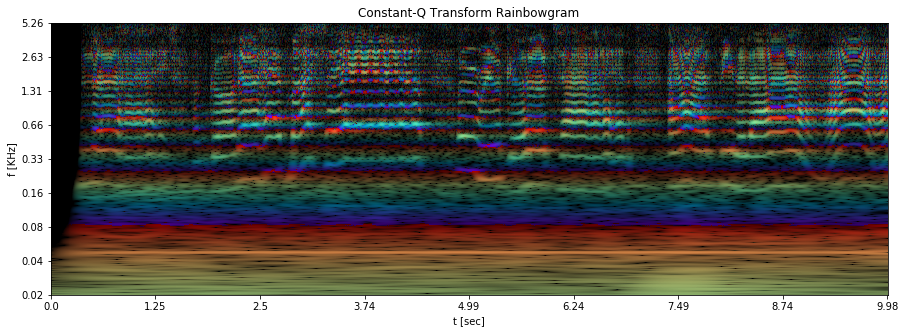

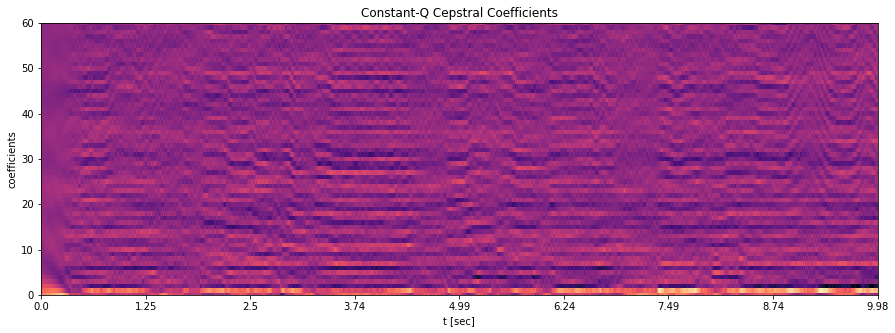

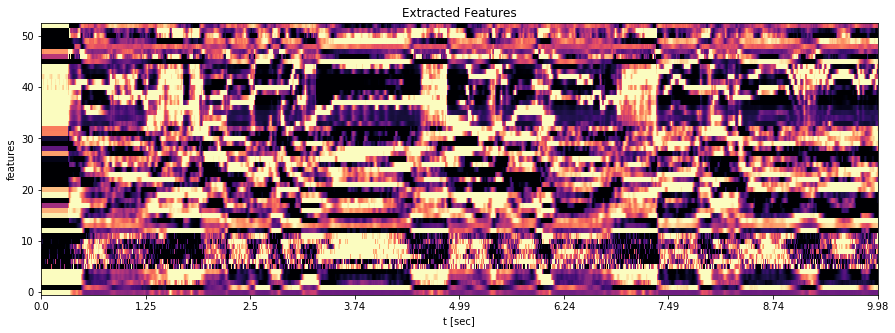

In [187]:
utils.visualize.display_all(x, figsize=figsize, cmap_spec=cmap_spec, 
                            display_rainbowgrams=True,
                            display_cepstrum=True)

### LPC Coefficients

In [53]:
import matplotlib.pyplot as plt
from IPython.display import Audio

In [54]:
import librosa
import numpy as np
import scipy

In [55]:
reload(utils.features)

<module 'utils.features' from '..\\utils\\features.py'>

In [56]:
n_fft = utils.extract.n_fft
n_window = utils.extract.n_fft
f_s = utils.extract.f_s
hop_length = utils.extract.hop_length
n_mels = utils.extract.params['mel']['n_mels']

#### single window

In [57]:
idx_start = 325000
wave = x['wave']['s'][idx_start:][:n_window]
t = x['wave']['t'][idx_start:][:n_window]
window = scipy.signal.windows.hann(n_window)

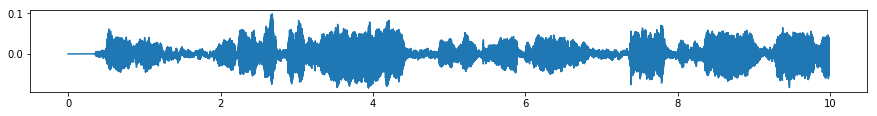

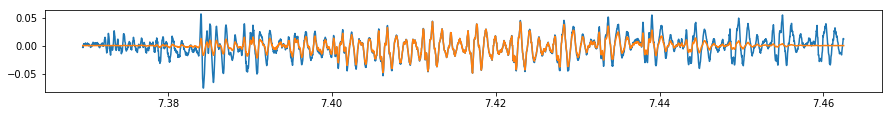

In [58]:
plt.figure(figsize=figsize)
plt.plot(x['wave']['t'], x['wave']['s'])
plt.show()

plt.figure(figsize=figsize)
plt.plot(t, wave)
plt.plot(t, wave*window)
plt.show()

display(Audio(wave*window, rate=f_s))

In [59]:
normalize = lambda x: x/np.sqrt(np.sum(x**2))

In [60]:
window = scipy.signal.windows.hann(n_window)

In [61]:
f = np.fft.rfftfreq(n_fft)*f_s

In [62]:
s_fft = np.fft.rfft(wave*window)
s_fft = normalize(s_fft)
s_fft_db = 20*np.log10(np.abs(s_fft))

In [63]:
m_order = 200
lpc_coeffs = utils.features.lpc(wave*window, order=m_order)
lpc_fd_db = utils.features.lpc_spectrum(lpc_coeffs, f_s, n_fft, return_db=True, return_f_positive=True, normalize=True)

In [64]:
idx_peaks = scipy.signal.find_peaks(lpc_fd_db)[0]
f_peaks = f[idx_peaks]
lpc_peaks_fd_db = lpc_fd_db[idx_peaks]

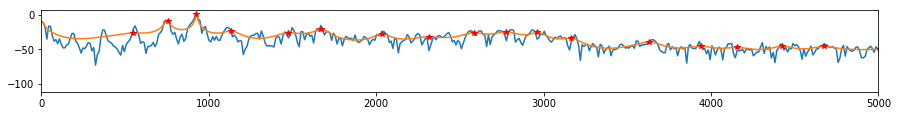

In [65]:
plt.figure(figsize=figsize)
plt.plot(f, s_fft_db)
plt.plot(f, lpc_fd_db)
plt.plot(f_peaks, lpc_peaks_fd_db, 'r*')
# plt.xlim([0, f_s/2])
plt.xlim([0, 5e3])
plt.show()

#### full record

In [66]:
reload(utils.features)

<module 'utils.features' from '..\\utils\\features.py'>

In [93]:
order = 10 # 10
n_ceps_coeffs = 300

In [94]:
lpc_coeffs_frames = utils.features.lpc_frames(x['wave']['s'], order, f_s, n_window, hop_length)

In [95]:
lpc_spec = utils.features.lpc_spectrogram(lpc_coeffs_frames, f_s, n_fft, return_mel=True, n_mels=n_mels)

In [96]:
lpcc = {}
for key in lpc_spec.keys():
    lpcc[key] = utils.trans.cepstrum(lpc_spec[key], n_coeffs=n_ceps_coeffs, idx_low_cut=0)

In [97]:
idx_peaks = [scipy.signal.find_peaks(s)[0] for s in lpc_spec['stft'].T]

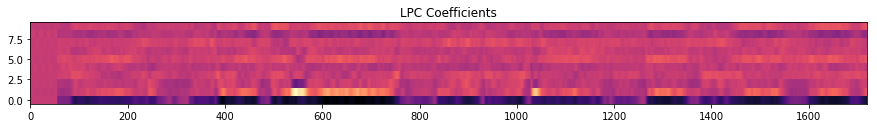

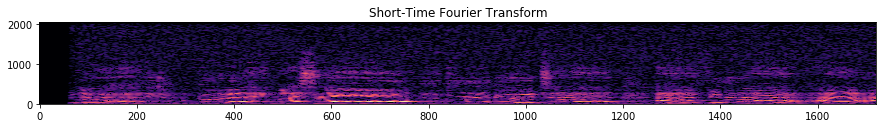

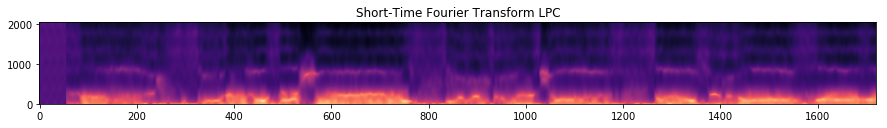

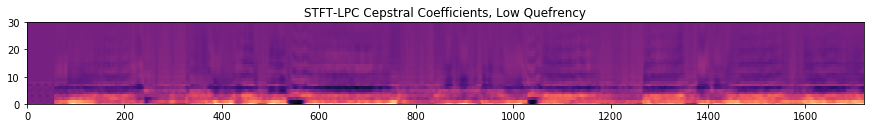

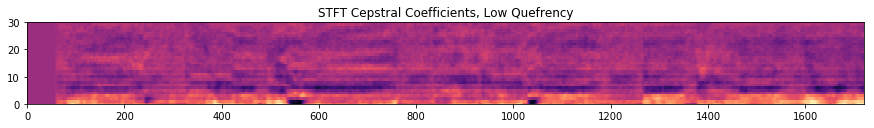

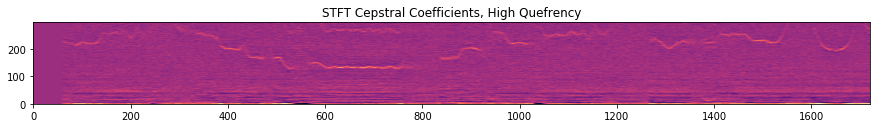

In [98]:
# display lpc coeffs:
plt.figure(figsize=figsize)
plt.imshow(lpc_coeffs_frames[1:], origin='lower', aspect='auto', cmap=cmap_spec)
plt.title('LPC Coefficients')
plt.show()

# display stft:
plt.figure(figsize=figsize)
plt.imshow(x['stft']['s'], origin='lower', aspect='auto', cmap=cmap_spec)
plt.title('Short-Time Fourier Transform')
plt.show()

# display lpc-stft:
plt.figure(figsize=figsize)
plt.imshow(lpc_spec['stft'], origin='lower', aspect='auto', cmap=cmap_spec)
plt.title('Short-Time Fourier Transform LPC')
plt.show()

idx_cut_cc = 2

# display lpc-stft cepstral coeffs:
plt.figure(figsize=figsize)
plt.imshow(lpcc['stft'][idx_cut_cc:], origin='lower', aspect='auto', cmap=cmap_spec)
plt.title('STFT-LPC Cepstral Coefficients, Low Quefrency')
plt.ylim([0, 30])
plt.show()

# display stft cepstral coeffs:
plt.figure(figsize=figsize)
plt.imshow(x['stft']['c'][idx_cut_cc:], origin='lower', aspect='auto', cmap=cmap_spec)
# plt.ylim([None, n_ceps_coeffs])
plt.title('STFT Cepstral Coefficients, Low Quefrency')
plt.ylim([0, 30])
plt.show()

# display stft cepstral coeffs:
plt.figure(figsize=figsize)
plt.imshow(x['stft']['c'][idx_cut_cc:], origin='lower', aspect='auto', cmap=cmap_spec)
# plt.ylim([None, n_ceps_coeffs])
plt.title('STFT Cepstral Coefficients, High Quefrency')
# plt.ylim([0, 30])
plt.show()

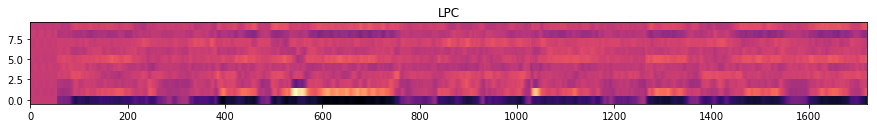

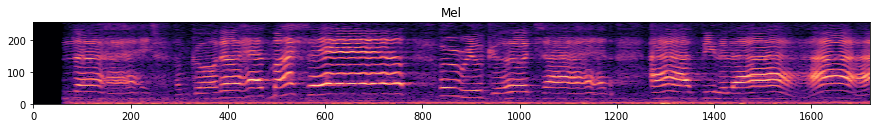

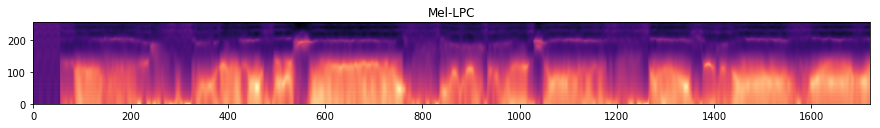

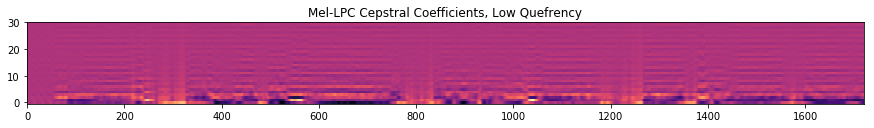

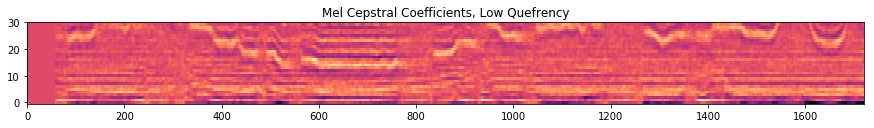

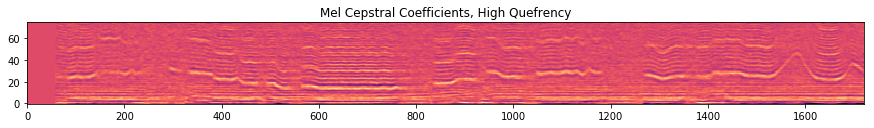

In [99]:
# display lpc coeffs:
plt.figure(figsize=figsize)
plt.imshow(lpc_coeffs_frames[1:], origin='lower', aspect='auto', cmap=cmap_spec)
plt.title('LPC')
plt.show()

# display mel:
plt.figure(figsize=figsize)
plt.imshow(x['mel']['s'], origin='lower', aspect='auto', cmap=cmap_spec)
plt.title('Mel')
plt.show()

# display lpc-mel:
plt.figure(figsize=figsize)
plt.imshow(lpc_spec['mel'], origin='lower', aspect='auto', cmap=cmap_spec)
plt.title('Mel-LPC')
plt.show()

idx_cut_cc = 2

# display lpc-mel cepstral coeffs:
plt.figure(figsize=figsize)
plt.imshow(lpcc['mel'][idx_cut_cc:], origin='lower', aspect='auto', cmap=cmap_spec)
plt.title('Mel-LPC Cepstral Coefficients, Low Quefrency')
plt.ylim([None, 30])
plt.show()

# display mel cepstral coeffs:
plt.figure(figsize=figsize)
plt.imshow(x['mel']['c'][idx_cut_cc:], origin='lower', aspect='auto', cmap=cmap_spec)
plt.ylim([None, 30])
plt.title('Mel Cepstral Coefficients, Low Quefrency')
plt.show()

# display mel cepstral coeffs:
plt.figure(figsize=figsize)
plt.imshow(x['mel']['c'][idx_cut_cc:], origin='lower', aspect='auto', cmap=cmap_spec)
plt.ylim([None, 75])
plt.title('Mel Cepstral Coefficients, High Quefrency')
plt.show()

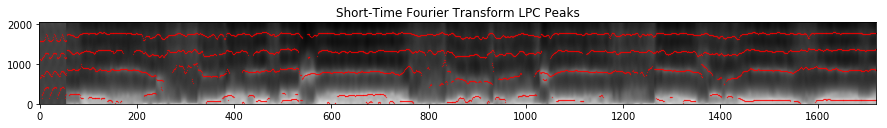

In [102]:
# display lpc-stft:
plt.figure(figsize=figsize)
plt.imshow(lpc_spec['stft'], origin='lower', aspect='auto', cmap='gray')
for i in range(len(idx_peaks)):
    plt.plot(i*np.ones(len(idx_peaks[i])), idx_peaks[i], 'r.', markersize=0.5)
plt.title('Short-Time Fourier Transform LPC Peaks')
plt.show()

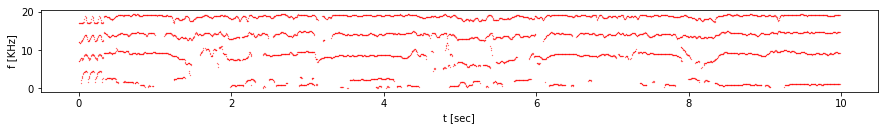

In [103]:
t = x['stft']['t']

plt.figure(figsize=figsize)
for i in range(len(idx_peaks)):
    plt.plot(t[i]*np.ones(len(idx_peaks[i])), f[idx_peaks[i]]*1e-3, 'r.', markersize=0.5)
plt.xlabel('t [sec]')
plt.ylabel('f [KHz]')
plt.show()

#### PCA on LPC coeffs

In [104]:
import sklearn
from sklearn.decomposition import PCA

In [104]:
y = lpc_coeffs_frames[1:]
n_components = order

pca = PCA(n_components=n_components)
pca.fit(y.T)

z_pca = pca.fit_transform(y.T).T
y_pca = pca.inverse_transform(z_pca.T).T

pca_explained_variance = pca.explained_variance_ratio_

pca_components = pca.inverse_transform(np.eye(n_components))
pca_components_rel = pca_components - np.mean(y, 1)

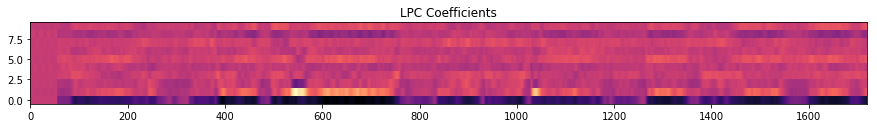

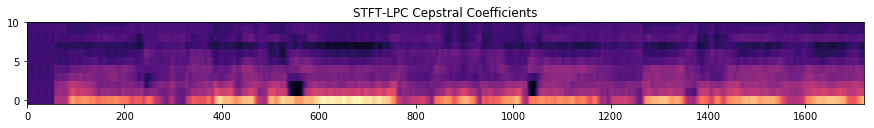

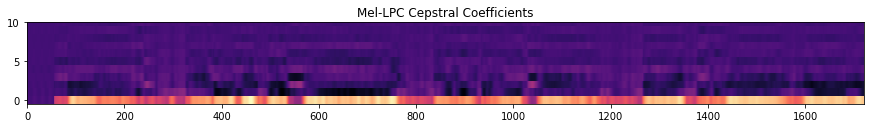

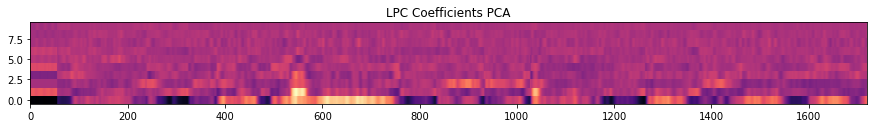

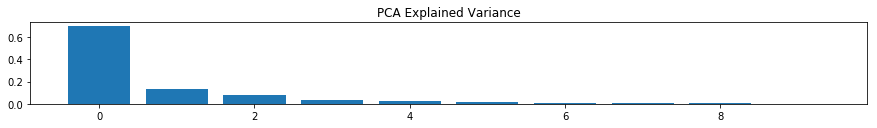

In [111]:
# display lpc coeffs:
plt.figure(figsize=figsize)
plt.imshow(lpc_coeffs_frames[1:], origin='lower', aspect='auto', cmap=cmap_spec)
plt.title('LPC Coefficients')
plt.show()

# display lpc-stft cepstral coeffs:
plt.figure(figsize=figsize)
plt.imshow(lpcc['stft'][1:], origin='lower', aspect='auto', cmap=cmap_spec)
plt.ylim([None, order])
plt.title('STFT-LPC Cepstral Coefficients')
plt.show()

# display lpc-mel cepstral coeffs:
plt.figure(figsize=figsize)
plt.imshow(lpcc['mel'][1:], origin='lower', aspect='auto', cmap=cmap_spec)
plt.ylim([None, order])
plt.title('Mel-LPC Cepstral Coefficients')
plt.show()

# display lpc pca coeffs:
plt.figure(figsize=figsize)
plt.imshow(z_pca, origin='lower', aspect='auto', cmap=cmap_spec)
plt.title('LPC Coefficients PCA')
plt.show()

plt.figure(figsize=figsize)
plt.bar(range(order), pca_explained_variance)
plt.title('PCA Explained Variance')
plt.show()

#### stacking LPC orders

In [168]:
order_list = [1, 25, 15]
n_ceps_coeffs = 300
n_orders = len(order_list)

lpc_coeffs = [None]*n_orders
lpc_spec = [None]*n_orders
lpcc = [None]*n_orders

In [169]:
for order, i in zip(order_list, range(n_orders)):
    print(order)
    lpc_coeffs[i] = utils.features.lpc_frames(x['wave']['s'], order, f_s, n_window, hop_length)
    lpc_spec[i] = utils.features.lpc_spectrogram(lpc_coeffs[i], f_s, n_fft)
    lpcc[i] = {}
    for key in lpc_spec[i].keys():
        lpcc[i][key] = utils.trans.cepstrum(lpc_spec[i][key], n_coeffs=n_ceps_coeffs, idx_low_cut=0)

1
25
15


In [170]:
for key in ['stft', 'mel']:
    lpc_spec[0][key] = x[key]['s']
    lpcc[0][key] = x[key]['c']

In [172]:
scale = lambda p: (p-p.min())/(p.max()-p.min())

In [173]:
lpc_spec_rgb = {}
lpcc_rgb = {}

for key in ['stft', 'mel']:
    lpc_spec_rgb[key] = scale(np.stack([s[key] for s in lpc_spec]).transpose(1,2,0))
    lpcc_rgb[key] = scale(np.stack([s[key] for s in lpcc]).transpose(1,2,0))

In [174]:
figsize = (15, 3)
# figsize = (15, 5)

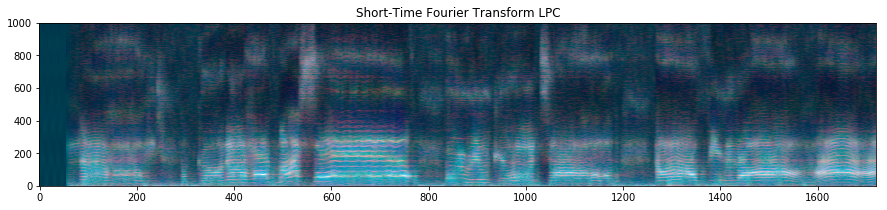

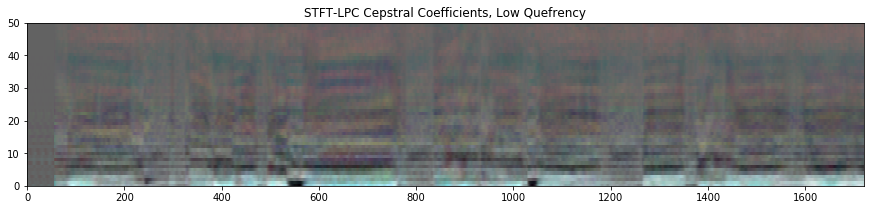

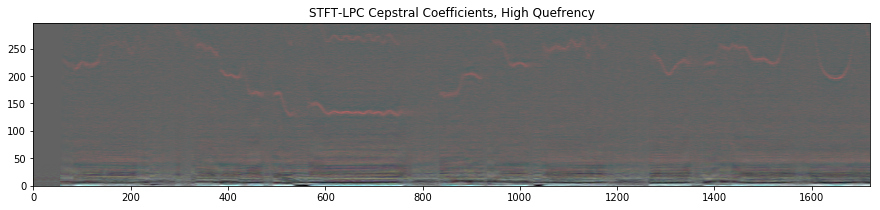

In [180]:
channels = [0,1,2]
# channels = [1,1,2]

# display stft lpc-sft:
plt.figure(figsize=figsize)
plt.imshow(lpc_spec_rgb['stft'][:,:,channels], origin='lower', aspect='auto')
plt.title('Short-Time Fourier Transform LPC')
plt.ylim([0, 1000])
plt.show()

idx_cut_cc = 2

# display lpc-stft cepstral coeffs:
plt.figure(figsize=figsize)
plt.imshow(scale(lpcc_rgb['stft'][idx_cut_cc:][:,:,channels]), origin='lower', aspect='auto')
plt.title('STFT-LPC Cepstral Coefficients, Low Quefrency')
plt.ylim([0, 50])
plt.show()

# display lpc-stft cepstral coeffs:
plt.figure(figsize=figsize)
plt.imshow(scale(lpcc_rgb['stft'][idx_cut_cc:][:,:,channels]), origin='lower', aspect='auto')
plt.title('STFT-LPC Cepstral Coefficients, High Quefrency')
# plt.ylim([0, 50])
plt.show()

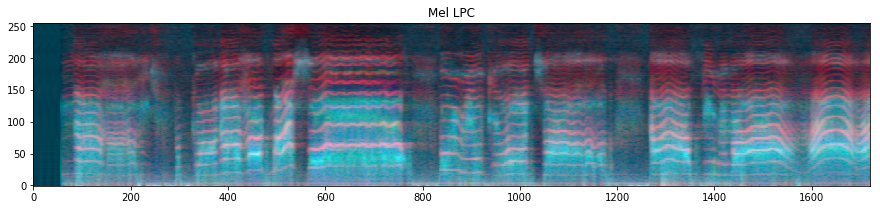

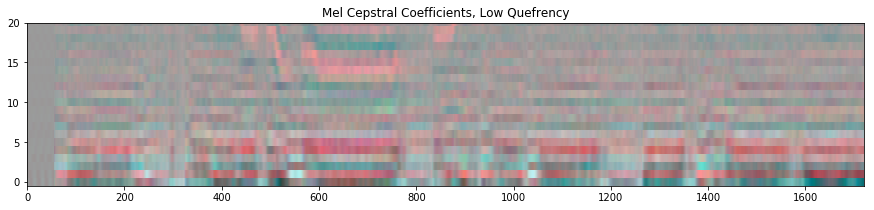

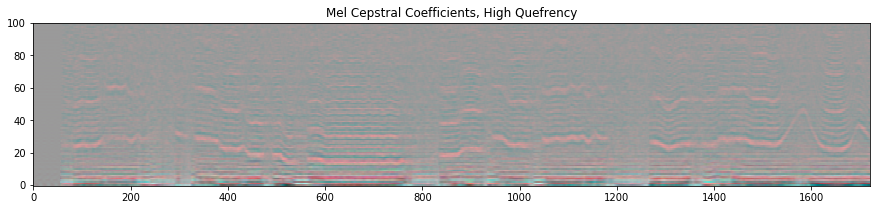

In [181]:
channels = [0,1,2]
# channels = [1,1,2]

# display mel lpc-sft:
plt.figure(figsize=figsize)
plt.imshow(lpc_spec_rgb['mel'][:,:,channels], origin='lower', aspect='auto')
plt.title('Mel LPC')
plt.show()

idx_cut_cc = 2

# display lpc-mel cepstral coeffs:
plt.figure(figsize=figsize)
plt.imshow(scale(lpcc_rgb['mel'][idx_cut_cc:][:,:,channels]), origin='lower', aspect='auto')
plt.title('Mel Cepstral Coefficients, Low Quefrency')
plt.ylim([None, 20])
plt.show()

# display lpc-mel cepstral coeffs:
plt.figure(figsize=figsize)
plt.imshow(scale(lpcc_rgb['mel'][idx_cut_cc:][:,:,channels]), origin='lower', aspect='auto')
plt.title('Mel Cepstral Coefficients, High Quefrency')
plt.ylim([None, 100])
plt.show()